In [561]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [562]:
#import configuration for selected file
from config import FieldM as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [563]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

In [564]:
from photutils.psf import BasicPSFPhotometry
from photutils.background import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
#from photutils.detection import DAOStarFinder, IRAFStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.datasets import make_gaussian_sources_image
from astropy.nddata import Cutout2D

In [565]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

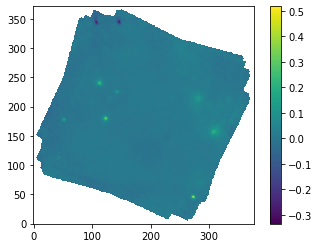

In [566]:
plt.figure()
plt.imshow(data,origin='lower')
plt.colorbar()
plt.show()

In [567]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_segCat.dat'):
    segTab=ascii.read(field.name+'_'+str(wavelength)+'um_segCat.dat')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_daoCat.dat'):   
    daoTab=ascii.read(field.name+'_'+str(wavelength)+'um_daoCat.dat')
else:
    daoTab=None

In [568]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = segdetsig*bkg_rms

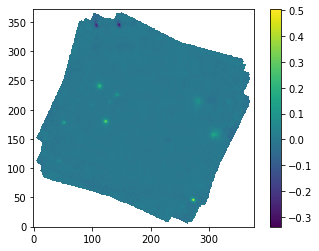

In [569]:
plt.figure()
plt.imshow(data_bkgsub,origin='lower')
plt.colorbar()
plt.show()

In [570]:
#remove nans to make life easier...
data_bkgsub[np.isnan(data_bkgsub)]=0

In [571]:
def dopsfphoto(image,bkgmodel,sources,sigma_init): 
	
	daogroup = DAOGroup(crit_separation=8)
	mmm_bkg = MedianBackground() #MedianBackground()#MMMBackground()
	fitter = LevMarLSQFitter()
	gaussian_prf = IntegratedGaussianPRF(sigma=sigma_init)
	gaussian_prf.sigma.fixed = False
	mmm_bkg.sigma_clip.fixed = False
	
	basic_phot_obj=BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=None, psf_model=gaussian_prf, fitter=fitter, fitshape=(15, 15))
	
	photB_results = basic_phot_obj(image,init_guesses=sources) #must provide initial guesses as an astropy table with columns x_0 and y_0 in pixel coords
	
	
	results=photB_results[photB_results['flux_fit']>0]
	results=results[(results['sigma_fit']>0) & (results['sigma_fit']<14) ]
	
	sources = Table()
	sources['flux'] = results['flux_fit']
	sources['x_mean'] = results['x_fit']
	sources['y_mean'] = results['y_fit']
	sources['x_stddev'] = results['sigma_fit']
	sources['y_stddev'] = sources['x_stddev']
	#sources['theta'] = [0] * 2
	
	modelimage = make_gaussian_sources_image(np.shape(data), sources)
	
	#residual=data-modelimage
	residual=data-(modelimage+bkgmodel) #include bkg model   
	    
	chivals=[]
	
	for source in photB_results:
		spos=(np.int(source['x_fit']),np.int(source['y_fit']))
		cutout=Cutout2D(residual,spos,15)
		#print(np.sum(cutout.data))
		fudge=100.
		chivals.append((np.nansum(cutout.data)/21.)**2*100)
		
	photB_results['psfFitChi']=chivals
	#print(chivals)
	
	#rename flux initial guess in table 
	photB_results.rename_column('flux', 'flux_init')
	    
	    
	return photB_results, residual#, chivals

In [572]:
#create initial guess positions for fitting routine
posSeg=Table()
posSeg['x_0']=segTab['xcentroid']
posSeg['y_0']=segTab['ycentroid']
posSeg['flux']=segTab['aper_snr_6as']

#create initial guess positions for fitting routine
posDao=Table()
posDao['x_0']=daoTab['xcentroid']
posDao['y_0']=daoTab['ycentroid']
posDao['flux']=daoTab['aper_snr_4as']

In [573]:
posDao

x_0,y_0,flux
float64,float64,float64
123.7,179.8,15.0824743966981
101.3,208.1,1.6887884583553447
130.5,213.3,2.1515745400192037
282.4,213.9,3.612757213912893
143.1,225.3,5.381449670224355
318.1,232.8,-0.17181668171273884
113.1,240.2,11.435601108151547
303.5,254.7,0.12445370599972023


In [574]:
dpsfresult,residual_dao=dopsfphoto(data_bkgsub,bkg,posDao,3.0)
spsfresult,residual_seg=dopsfphoto(data_bkgsub,bkg,posSeg,4.0)

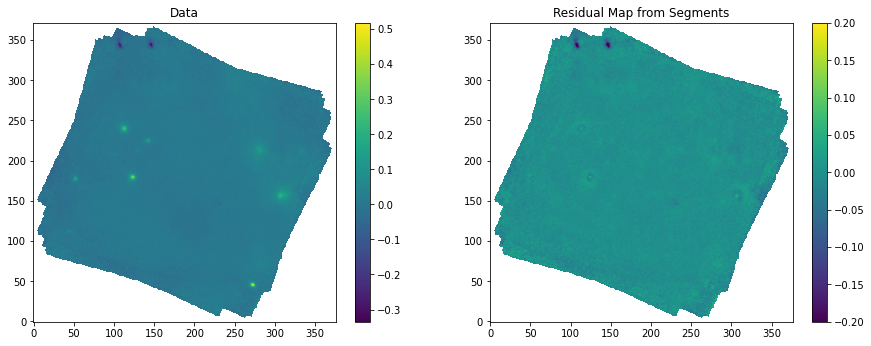

In [575]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Data')
p1=ax1.imshow(data,origin='lower')
fig.colorbar(p1, ax=ax1)


ax2.set_title('Residual Map from Segments')
p2=ax2.imshow(residual_seg,origin='lower',vmin=-0.2,vmax=0.2)
fig.colorbar(p2, ax=ax2)

plt.show()

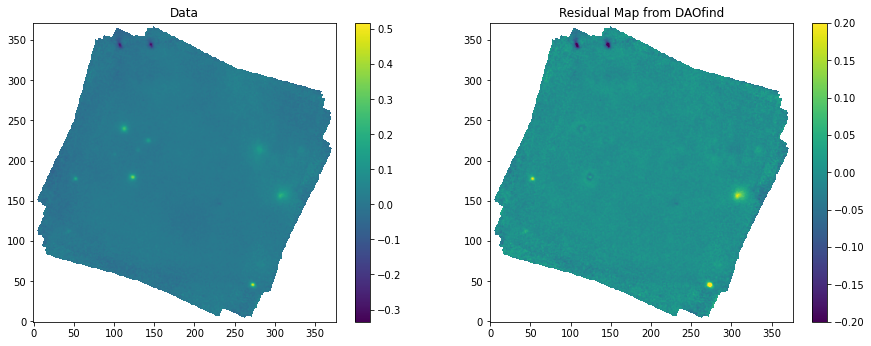

In [576]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Data')
p1=ax1.imshow(data,origin='lower')
fig.colorbar(p1, ax=ax1)


ax2.set_title('Residual Map from DAOfind')
p2=ax2.imshow(residual_dao,origin='lower',vmin=-0.2,vmax=0.2)
fig.colorbar(p2, ax=ax2)

plt.show()

In [577]:
spsfresult

x_0,y_0,flux_init,flux_0,sigma_0,id,group_id,x_fit,y_fit,flux_fit,sigma_fit,flux_unc,x_0_unc,y_0_unc,sigma_unc,psfFitChi
float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
272.8,45.9,6.923725571335331,11.35623775601854,4.0,1,1,272.95563580490926,45.86756383429538,10.7722600848716,1.8859876716959225,0.16431182929748053,0.02910345936103157,0.029101843526254067,0.020825278444501497,0.08981443059450017
43.67,112.2,3.9477451629709215,1.913952320693678,4.0,2,2,43.68634851959339,112.25423298717766,1.600922586079676,2.1569921889788013,0.10634279783815075,0.14454073169600404,0.14454142466727396,0.10316093092984006,0.018422216916199347
308.9,157.7,5.846651489697923,19.86807713587758,4.0,3,3,308.9755674593981,157.3138727721592,23.143444955570697,4.9121926636572,0.5512811289260074,0.09300928029964659,0.0939113881252557,0.08566420335194372,0.024245337643095465
123.3,179.3,12.757251857332566,16.672697962168535,4.0,4,4,123.48767512216416,179.7500030260537,14.514252562388393,2.674217567694822,0.2251360503340135,0.04154963941976073,0.041566866671206446,0.029761759677979217,0.49193317983584467
52.24,177.9,10.737114755187454,5.033452953165,4.0,5,5,52.435182288754326,177.82663918344795,4.36691427388551,1.883544017402213,0.0970115458756014,0.04233082849968469,0.04233175199210133,0.030292594277878105,0.11344982924145647
280.8,213.8,4.01544979588643,11.530835467691835,4.0,6,6,281.07696283043157,213.9917181619181,13.308797288643813,4.879072168898554,0.24627217851634367,0.07269463929863137,0.07268374257678084,0.06632140319206058,0.0010541181007209413
101.2,208.2,1.5326335438561993,1.1600533367822594,4.0,7,7,101.07960506886612,208.1457396991179,0.8350093866843711,1.7928305811309995,0.05395774462991455,0.11734329426713759,0.11734658577689312,0.08407498939658688,0.012490743408541201
130.3,213.6,1.7203816340771658,1.071941805694457,4.0,8,8,130.40081534573227,213.65365833033647,1.2728031448479271,2.062173409247645,0.06153341786259748,0.10066150432840631,0.1006632560306475,0.07189865147311315,0.002476590477607438
332.8,213.5,1.5825930283190413,1.6407510660722666,4.0,9,9,333.24182557080945,213.20315340821628,1.9538311699692443,3.038236499982153,0.11669163587781366,0.18028371586861888,0.1802682234757117,0.1304531233965536,0.004881498761852387


In [578]:
mtdao = join(daoTab,dpsfresult, keys='id')
mtseg = join(segTab,spsfresult, keys='id')

In [579]:
mtseg

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv,x_0,y_0,flux_init,flux_0,sigma_0,group_id,x_fit,y_fit,flux_fit,sigma_fit,flux_unc,x_0_unc,y_0_unc,sigma_unc,psfFitChi
int32,float64,float64,str38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str38,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,272.8,45.9,"266.50983223696716,-28.956433928122838",-0.004751,0.01393,1.17,84,2.156,1.704,-33.93,0.2553,0.1196,0.304,0.6125,0.2095,1.265,4.577,10.21,0.1536,0.9577,10.88,0.1725,0.01426,0.01402,0.001303,9.367,"266.50983223696716,-28.956433928122838",6.70234178144291,0.08753340376342894,11.891869972133152,0.1758387786414043,14.332593987054207,0.2694446185486397,15.839302562929042,0.363580975488142,17.5463143224626,0.45894088768027524,0.011567458871131742,0.011664188185816143,12.114561566329408,0.2694446185486397,0.01156745887113174,191.74759516631747,830.906245720709,6.923725571335331,6.45589373469571,10.906077785144351,11.896133814973846,11.385113153782605,11.030558640802807,9.636794020161135,4.8270520548266695,3.454188337188916,11.030558640802807,C7FieldM,25,272.8,45.9,6.923725571335331,11.35623775601854,4.0,1,272.95563580490926,45.86756383429538,10.7722600848716,1.8859876716959225,0.16431182929748053,0.02910345936103157,0.029101843526254067,0.020825278444501497,0.08981443059450017
2,43.67,112.2,"266.56570009007885,-28.942298615521207",-0.00332,0.002909,0.07563,26,1.662,1.095,29.06,0.4734,-0.4004,0.7224,0.7521,0.3409,1.517,3.314,1.703,0.2086,2.205,0.9765,0.08331,0.002939,0.002985,0.0002361,2.434,"266.56570009007885,-28.942298615521207",0.8681507265489641,0.07547131646170104,1.730585252817893,0.1483326046768084,2.355470610242876,0.22040532330062548,2.988702584690765,0.29158552411481314,3.249859795004904,0.3633034374310436,0.00028893442175546646,0.0005375968238999784,2.300068129710495,0.22040532330062548,0.0002889344217554664,191.74759516631747,830.906245720709,3.9477451629709215,0.8619948953786994,1.705961928136835,2.8902092859665314,3.0959640157482893,2.979131622554318,3.9066066309382834,3.8967636389272786,3.3605417212093283,3.9477451629709215,C7FieldM,25,43.67,112.2,3.9477451629709215,1.913952320693678,4.0,2,43.68634851959339,112.25423298717766,1.600922586079676,2.1569921889788013,0.10634279783815075,0.14454073169600404,0.14454142466727396,0.10316093092984006,0.018422216916199347
3,308.9,157.7,"266.5010458671182,-28.932586411759328",0.01321,0.03854,10.83,281,4.305,3.84,51.46,0.06243,-0.01352,0.05933,0.4522,0.1081,1.121,9.606,29.85,0.433,1.952,19.79,0.206,0.03815,0.0383,0.001277,5.975,"266.5010458671182,-28.932586411759328",4.019125900161823,0.057406402473601,13.159114080679442,0.11480283887713442,23.794309034755848,0.1709632135737824,34.81530441532667,0.22653729317040117,45.766020244612946,0.28110001578006283,0.0351567305624485,0.03280317626631099,17.05309049549617,0.1709632135737824,0.0351

In [580]:
#write out the resulting table to file
ascii.write(mtdao, field.name+'_25um_cat_daoprf.dat', overwrite=True)
ascii.write(mtseg, field.name+'_25um_cat_segprf.dat', overwrite=True)

In [581]:
fits.writeto(field.filename[:-12]+'resid_DAO.fits', residual_dao,overwrite=True)
fits.writeto(field.filename[:-12]+'resid_SEG.fits', residual_seg,overwrite=True)